Reading data from: ../data/raw/DMSO
Will save processed data to: ../data/processed/DMSO/CH1
Loaded image: MCF7_AREG_DMSO_016.tif
Original image shape (Z, C, Y, X): (15, 2, 512, 512)
Shape after selecting channel 1: (15, 512, 512)


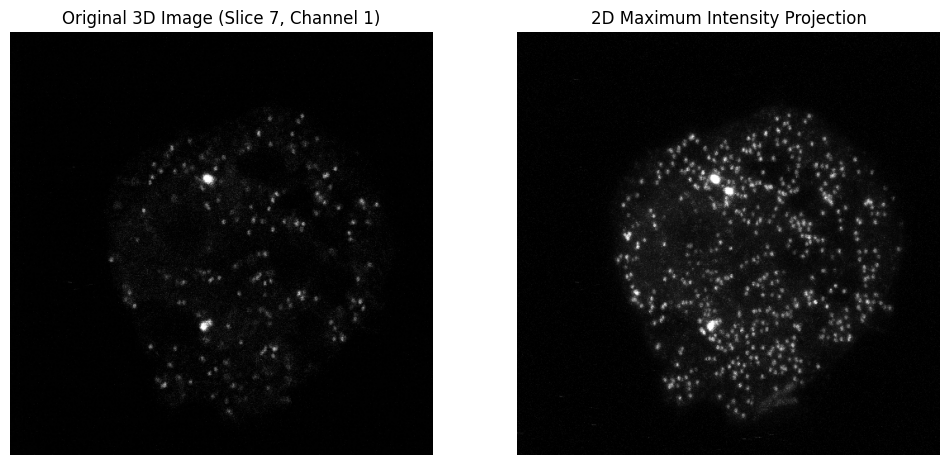


--- Starting batch processing for: DMSO ---
  - Processed and saved: MCF7_AREG_DMSO_016_ch1_projection.tif
  - Processed and saved: MCF7_AREG_DMSO_002_ch1_projection.tif
  - Processed and saved: MCF7_AREG_DMSO_003_ch1_projection.tif
  - Processed and saved: MCF7_AREG_DMSO_015_ch1_projection.tif
  - Processed and saved: MCF7_AREG_DMSO_017_ch1_projection.tif
  - Processed and saved: MCF7_AREG_DMSO_001_ch1_projection.tif
  - Processed and saved: MCF7_AREG_DMSO_014_ch1_projection.tif
  - Processed and saved: MCF7_AREG_DMSO_004_ch1_projection.tif
  - Processed and saved: MCF7_AREG_DMSO_010_ch1_projection.tif
  - Processed and saved: MCF7_AREG_DMSO_007_ch1_projection.tif
  - Processed and saved: MCF7_AREG_DMSO_011_ch1_projection.tif
  - Processed and saved: MCF7_AREG_DMSO_006_ch1_projection.tif
  - Processed and saved: MCF7_AREG_DMSO_012_ch1_projection.tif
  - Processed and saved: MCF7_AREG_DMSO_023_ch1_projection.tif
  - Processed and saved: MCF7_AREG_DMSO_022_ch1_projection.tif
  - Proces

In [29]:
import os
import numpy as np
import tifffile
import matplotlib.pyplot as plt
from skimage.filters import gaussian

BASE_DIR = ".."
RAW_DATA_DIR = os.path.join(BASE_DIR, "data", "raw")
PROCESSED_DATA_DIR = os.path.join(BASE_DIR, "data", "processed", "DMSO", "CH1")

# Choose DMSO or JQ1 or TSA
CONDITION_DIR = os.path.join(RAW_DATA_DIR, "DMSO")

os.makedirs(PROCESSED_DATA_DIR, exist_ok=True)

print(f"Reading data from: {CONDITION_DIR}")
print(f"Will save processed data to: {PROCESSED_DATA_DIR}")

image_files = [f for f in os.listdir(CONDITION_DIR) if f.endswith(('.tif', '.tiff'))]

CHANNEL_TO_PROCESS = 1

if image_files:
    image_path = os.path.join(CONDITION_DIR, image_files[0])
    image_3d_multi_channel = tifffile.imread(image_path)
    
    print(f"Loaded image: {image_files[0]}")
    print(f"Original image shape (Z, C, Y, X): {image_3d_multi_channel.shape}")

    image_3d_single_channel = image_3d_multi_channel[:, CHANNEL_TO_PROCESS, :, :]
    print(f"Shape after selecting channel {CHANNEL_TO_PROCESS}: {image_3d_single_channel.shape}")

    # Calculate max. int.
    projection_2d = np.max(image_3d_single_channel, axis=0)

    # Plot
    middle_slice_index = image_3d_single_channel.shape[0] // 2
    middle_slice = image_3d_single_channel[middle_slice_index, :, :]

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(middle_slice, cmap='gray')
    axes[0].set_title(f'Original 3D Image (Slice {middle_slice_index}, Channel {CHANNEL_TO_PROCESS})')
    axes[0].axis('off')

    axes[1].imshow(projection_2d, cmap='gray')
    axes[1].set_title('2D Maximum Intensity Projection')
    axes[1].axis('off')
    plt.show()

def preprocess_and_save(condition_folder, output_folder, channel_index, sigma=1.0):
    """
    Loads all 3D TIFFs from a folder, selects a channel, calculates the 
    smoothed 2D max projection, and saves them to the output folder.
    """
    print(f"\n--- Starting batch processing for: {os.path.basename(condition_folder)} ---")
    
    image_files = [f for f in os.listdir(condition_folder) if f.endswith(('.tif', '.tiff'))]
    
    if not image_files:
        print("No images found to process.")
        return

    for filename in image_files:
        try:
            input_path = os.path.join(condition_folder, filename)
            output_filename = filename.replace('.tif', f'_ch{channel_index}_projection.tif')
            output_path = os.path.join(output_folder, output_filename)

            image_3d_mc = tifffile.imread(input_path)
            
            image_3d_sc = image_3d_mc[:, channel_index, :, :]

            # Max projection
            projection_2d = np.max(image_3d_sc, axis=0)

            # Gaussian
            smoothed_projection = gaussian(projection_2d, sigma=sigma)
            
            if np.issubdtype(image_3d_mc.dtype, np.integer):
                 max_val = np.iinfo(image_3d_mc.dtype).max
                 smoothed_projection_to_save = (smoothed_projection * max_val).astype(image_3d_mc.dtype)
            else:
                 smoothed_projection_to_save = smoothed_projection

            tifffile.imwrite(output_path, smoothed_projection_to_save)
            print(f"  - Processed and saved: {output_filename}")

        except Exception as e:
            print(f"  - Failed to process {filename}: {e}")
            
    print("--- Batch processing complete. ---")

preprocess_and_save(
    condition_folder=CONDITION_DIR, 
    output_folder=PROCESSED_DATA_DIR, 
    channel_index=CHANNEL_TO_PROCESS, 
    sigma=1.0
)